In [1]:
from utils.preprocess_data import load_dataset
from utils.plots import plot_results
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import SplineTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import os
import time


In [2]:
do_grid_search = False
do_random_search = False
add_smoothing = False
add_squares = False

errors = []
best_hyperparameters = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0}

In [3]:
train_data = load_dataset(split="train")
val_data = load_dataset(split="valid")



features_base = ["xR","yR", "theta"]

if add_squares:
    # add squares
    xR_squared_train = np.square(train_data["xR"])
    yR_squared_train = np.square(train_data["yR"])
    df_train_sqr = pd.DataFrame({"xR_sqr":xR_squared_train,"yR_sqr":yR_squared_train})

    xR_squared_val = np.square(val_data["xR"])
    yR_squared_val = np.square(val_data["yR"])
    df_val_sqr = pd.DataFrame({"xR_sqr":xR_squared_val,"yR_sqr":yR_squared_val})

if add_smoothing:
    # add smoothing
    dfs = []
    for trial_num in range(len(os.listdir("data/train"))):

        smoothed_xR_train = savgol_filter(train_data.loc[trial_num,"xR"], window_length=5, polyorder=3)
        smoothed_yR_train = savgol_filter(train_data.loc[trial_num,"yR"], window_length=5, polyorder=3)
        
        df = pd.DataFrame({"xR_smooth":smoothed_xR_train,"yR_smooth":smoothed_yR_train})
        df["trial_num"] = trial_num
        df["timepoint"] = df.index
        df.set_index(['trial_num', 'timepoint'], inplace=True)
        dfs.append(df)
    df_train_smooth = pd.concat(dfs, axis=0)

    dfs = []
    for trial_num in range(len(os.listdir("data/valid"))):

        smoothed_xR_val = savgol_filter(val_data.loc[trial_num,"xR"], window_length=20, polyorder=3)
        smoothed_yR_val = savgol_filter(val_data.loc[trial_num,"yR"], window_length=20, polyorder=3)
        df = pd.DataFrame({"xR_smooth":smoothed_xR_val,"yR_smooth":smoothed_yR_val})
        df["trial_num"] = trial_num
        df["timepoint"] = df.index
        df.set_index(['trial_num', 'timepoint'], inplace=True)
        dfs.append(df)
    df_val_smooth = pd.concat(dfs, axis=0)
    del df 
    del dfs
    # add polynomial fit 

    train_data = pd.concat([train_data,df_train_smooth, df_train_sqr ],axis=1)
    val_data = pd.concat([val_data,df_val_smooth, df_val_sqr],axis=1)

if add_squares and add_smoothing:
    features = features_base  + ["xR_sqr", "yR_sqr"] + ["xR_smooth","yR_smooth"]
elif add_smoothing:
    features = features_base + ["xR_smooth","yR_smooth"]
elif add_squares:
    features = features_base + ["xR_sqr", "yR_sqr"]
else:
    features =  features_base
    

In [4]:
if do_grid_search:
    
   # Define the parameter grid to search
    param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 4, 5],  # Maximum depth of each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a split
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting individual base learners
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for fitting individual base learners
    'reg_lambda': [0.1, 1, 10],  # L2 regularization term
    'reg_alpha': [0, 0.1, 1]  # L1 regularization term
    }


    # Create an XGBoost regressor
    bst = XGBRegressor()

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=bst, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=4 , verbose=2)

    # Fit the model to the data
    grid_search.fit(train_data[features], train_data[["xV","yV"]])

    # Get the best hyperparameters
    best_hyperparameters = grid_search.best_params_
    print("Best Hyperparameters:", best_hyperparameters)

xgb_model = XGBRegressor(**best_hyperparameters)
#xgb_model = XGBRegressor(n_estimators=10, max_depth=20, learning_rate=1)

xgb_model.fit(train_data[features], train_data[["xV","yV"]])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

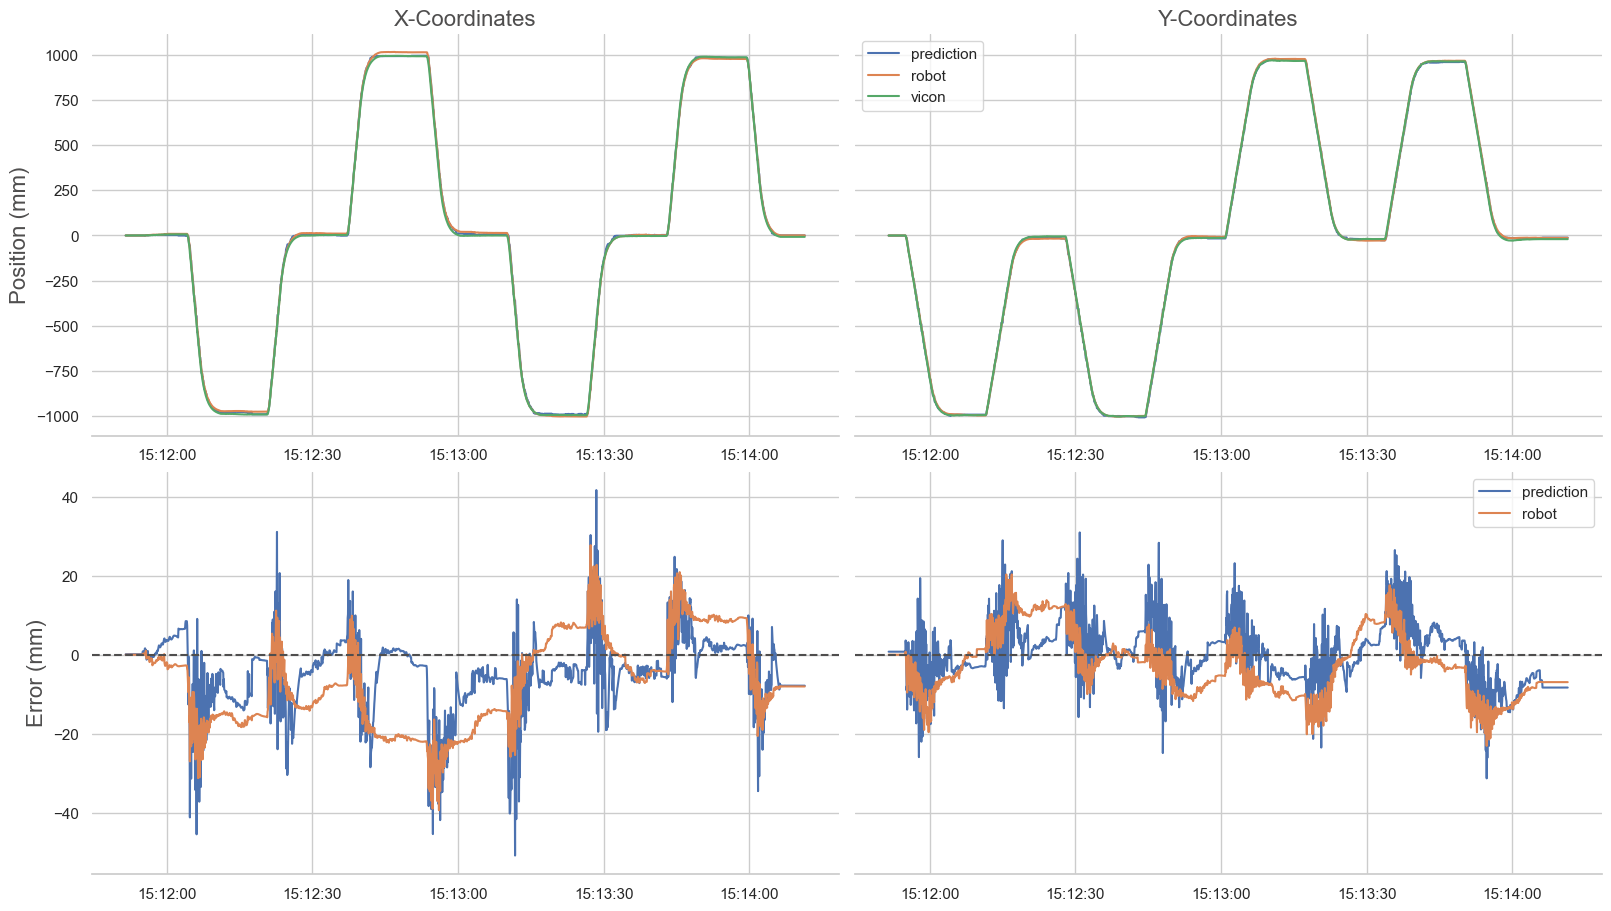

Mean Absolute Error XGB: [7.26658123 5.82352819]
Mean Absolute Error ROBOT: [10.98994519  6.96777839]
Final Error ROBOT [-8.03852184 -6.94215962]
Final Error XGB: [-7.84131986 -8.31380828]


In [5]:
trial_num = 1

time_axis = val_data.loc[trial_num, "tStart_datetime"].to_numpy()
predictions = xgb_model.predict(val_data.loc[trial_num,features].to_numpy())
robot = val_data.loc[trial_num, ["xR","yR"]].to_numpy()
vicon = val_data.loc[trial_num, ["xV","yV"]].to_numpy()


plot_results(time_axis, predictions, robot, vicon, euclidean=False)
mae_xgb = mean_absolute_error(y_true=vicon,y_pred=predictions,multioutput="raw_values")
mae_robot = mean_absolute_error(y_true=vicon,y_pred=robot,multioutput="raw_values")

#mape_xgb = mean_absolute_percentage_error(y_true=vicon,y_pred=predictions,multioutput="raw_values")
#mape_robot = mean_absolute_percentage_error(y_true=vicon,y_pred=robot,multioutput="raw_values")


final_error_robot = vicon[-1] - robot[-1]
final_error_xgb = vicon[-1] - predictions[-1]
print(f"Mean Absolute Error XGB: {mae_xgb}")
print(f"Mean Absolute Error ROBOT: {mae_robot}")

#print(f"Mean Absolute Percentage Error XGB: {mape_xgb}")
#print(f"Mean Absolute Percentage Error ROBOT: {mape_robot}")

print(f"Final Error ROBOT {final_error_robot}")
print(f"Final Error XGB: {final_error_xgb}")

# Results

MAPE is not helpful in this case, as the y_true can be zero or close to zero yielding very high MAPE

## Train

In [6]:
results_train = []
for trial_num in range(len(os.listdir("data/train"))):
    predictions = xgb_model.predict(train_data.loc[trial_num,features].to_numpy())
    robot = train_data.loc[trial_num, ["xR","yR"]].to_numpy()
    vicon = train_data.loc[trial_num, ["xV","yV"]].to_numpy()
    
    mae_xgb = mean_absolute_error(y_true=vicon,y_pred=predictions,multioutput="raw_values")
    mae_robot = mean_absolute_error(y_true=vicon,y_pred=robot,multioutput="raw_values")

    final_error_robot = abs(vicon[-1] - robot[-1])
    final_error_xgb = abs(vicon[-1] - predictions[-1])



    results_train.append({
        "mae_robot_x": mae_robot[0],
        "mae_robot_y": mae_robot[1],
        "fe_robot_x": final_error_robot[0],
        "fe_robot_y": final_error_robot[1],

        "mae_xgb_x": mae_xgb[0],
        "mae_xgb_y": mae_xgb[1],
        "fe_xgb_x": final_error_xgb[0],
        "fe_xgb_y": final_error_xgb[1],
        
    })

df_results_train = pd.DataFrame(results_train)

# Calculate averages for each column
averages = df_results_train.mean()

# Append the averages as a new row to the DataFrame
df_results_train = df_results_train.append(np.round(averages,2), ignore_index=True)


df_results_train


C:\Users\nowak\AppData\Local\Temp\ipykernel_27776\2523442340.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_train = df_results_train.append(np.round(averages,2), ignore_index=True)


,mae_robot_x,mae_robot_y,fe_robot_x,fe_robot_y,mae_xgb_x,mae_xgb_y,fe_xgb_x,fe_xgb_y
0,13.900658,13.541469,17.260058,3.675243,4.411502,3.557589,0.340146,2.042223
1,25.011589,11.918106,21.227883,3.436640,5.493525,3.488747,4.154112,0.556146
2,14.602742,15.510552,17.028194,25.234419,4.001239,4.083258,2.237807,3.822236
3,4.841091,6.761174,7.032913,5.751636,5.019718,5.486260,2.077635,3.439990
4,11.085792,6.487472,1.630173,3.194891,5.018866,3.635013,7.667237,3.961457
5,6.630222,7.735600,0.020297,13.582291,3.881645,4.327445,0.171932,5.690336
6,5.175870,3.778953,1.526055,2.652775,3.171186,4.043260,1.724479,1.425087
7,8.069223,10.794816,16.202633,13.067896,4.431185,3.090117,5.220698,0.501463
8,11.160000,9.570000,10.240000,8.820000,4.430000,3.960000,2.950000,2.680000


## Validation

In [7]:
results_valid = []
for trial_num in range(len(os.listdir("data/valid"))):
    predictions = xgb_model.predict(val_data.loc[trial_num,features].to_numpy())
    robot = val_data.loc[trial_num, ["xR","yR"]].to_numpy()
    vicon = val_data.loc[trial_num, ["xV","yV"]].to_numpy()
    
    mae_xgb = mean_absolute_error(y_true=vicon,y_pred=predictions,multioutput="raw_values")
    mae_robot = mean_absolute_error(y_true=vicon,y_pred=robot,multioutput="raw_values")

    final_error_robot = abs(vicon[-1] - robot[-1])
    final_error_xgb = abs(vicon[-1] - predictions[-1])



    results_valid.append({
        "mae_robot_x": mae_robot[0],
        "mae_robot_y": mae_robot[1],
        "fe_robot_x": final_error_robot[0],
        "fe_robot_y": final_error_robot[1],

        "mae_xgb_x": mae_xgb[0],
        "mae_xgb_y": mae_xgb[1],
        "fe_xgb_x": final_error_xgb[0],
        "fe_xgb_y": final_error_xgb[1],
        
    })

df_results_valid = pd.DataFrame(results_valid)

# Calculate averages for each column
averages = df_results_valid.mean()

# Append the averages as a new row to the DataFrame
df_results_valid = df_results_valid.append(np.round(averages,2), ignore_index=True)


df_results_valid

C:\Users\nowak\AppData\Local\Temp\ipykernel_27776\1439598105.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results_valid = df_results_valid.append(np.round(averages,2), ignore_index=True)


,mae_robot_x,mae_robot_y,fe_robot_x,fe_robot_y,mae_xgb_x,mae_xgb_y,fe_xgb_x,fe_xgb_y
0,3.060699,5.337488,4.637420,3.786709,7.047274,5.522236,0.093468,5.758235
1,10.989945,6.967778,8.038522,6.942160,7.266581,5.823528,7.841320,8.313808
2,11.236921,2.997917,9.367689,4.212245,10.170710,7.268594,0.042175,4.616118
3,8.430000,5.100000,7.350000,4.980000,8.160000,6.200000,2.660000,6.230000


## Inference Time

In [8]:


test_input = np.zeros((1, 3))

inf_times = []
for i in range(1):
    t_start = time.time()
    xgb_model.predict(test_input)
    inf_times.append(time.time()-t_start)

print(f'Inference Time: {np.mean(inf_times)*1000} ms')


Inference Time: 0.9968280792236328 ms


# Smoothing

In [9]:
def apply_savgol(predictions, window_size):
    x = savgol_filter(predictions[:,0], window_length=window_size, polyorder=3)
    y = savgol_filter(predictions[:,1], window_length=window_size, polyorder=3)

    return np.vstack((x,y))

In [10]:
def apply_moving_average(predictions, window_size):
    def moving_average(arr, window_size):
        """
        Compute the moving average of a numpy array with padding.

        Parameters:
            arr (numpy.ndarray): The input array.
            window_size (int): The size of the moving window.

        Returns:
            numpy.ndarray: The moving average array with padding.
        """
        cumsum = np.cumsum(arr, dtype=float)
        cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
        moving_avg = cumsum[window_size - 1:] / window_size

        # Pad the result to have the same length as the input array
        padding = np.full_like(arr, np.nan)
        moving_avg = np.concatenate((padding[:window_size-1], moving_avg))

        return moving_avg

    # Use numpy's convolve function to calculate the moving average
    x = moving_average(predictions[:,0],window_size)
    y= moving_average(predictions[:,1],window_size)

    return np.vstack((x,y))

In [11]:
def apply_exponential_smoothing(predictions, alpha):
    def exponential_smoothing(x, alpha):
        """
        Apply exponential smoothing to the given data.

        Parameters:
            x (array-like): The input data to be smoothed.
            alpha (float): Smoothing factor (0 < alpha < 1).

        Returns:
            array-like: Smoothed data.
        """
        smoothed = np.zeros_like(x)
        smoothed[0] = x[0]
        for i in range(1, len(x)):
            smoothed[i] = alpha * x[i] + (1 - alpha) * smoothed[i-1]
        return smoothed
    x = exponential_smoothing(predictions[:,0], alpha)
    y = exponential_smoothing(predictions[:,1], alpha)
    return np.vstack((x,y))

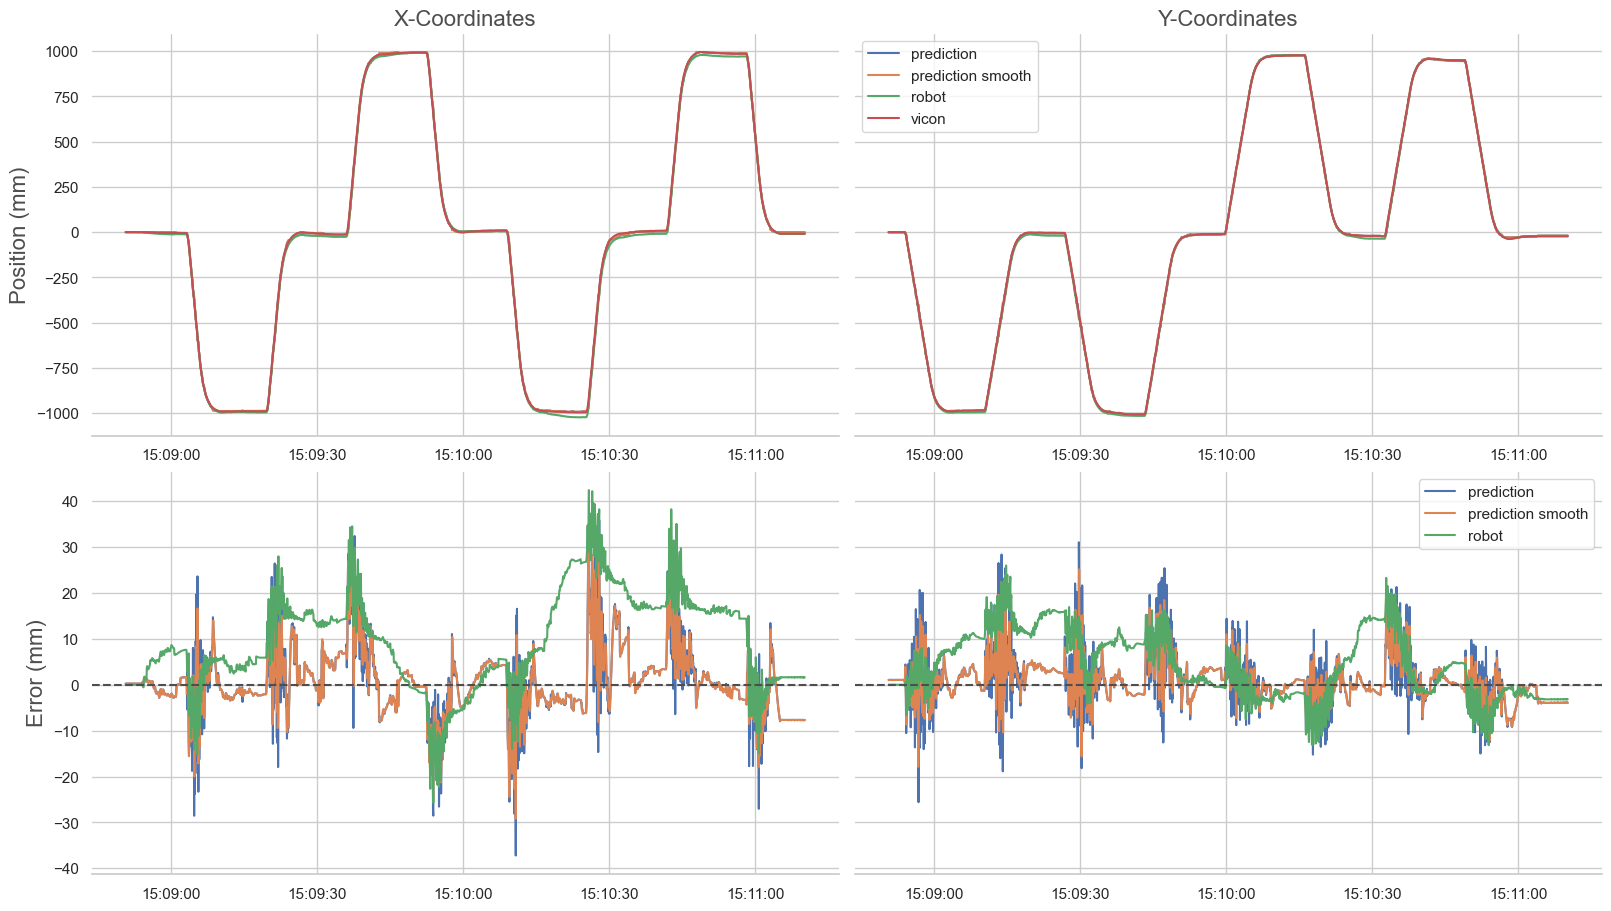

Mean Absolute Error XGB: [5.01886645 3.63501329]
Mean Absolute Error ROBOT: [11.08579231  6.4874725 ]


In [12]:
trial_num = 4

time_axis = train_data.loc[trial_num, "tStart_datetime"].to_numpy()
predictions = xgb_model.predict(train_data.loc[trial_num,features].to_numpy())
robot = train_data.loc[trial_num, ["xR","yR"]].to_numpy()
vicon = train_data.loc[trial_num, ["xV","yV"]].to_numpy()

smoothed_pred = apply_savgol(predictions, window_size=5)
# TODO apply smoothing to error
plot_results(time_axis, predictions, robot, vicon,smoothed=smoothed_pred.T, euclidean=False)
mae_xgb = mean_absolute_error(y_true=vicon,y_pred=predictions,multioutput="raw_values")
mae_robot = mean_absolute_error(y_true=vicon,y_pred=robot,multioutput="raw_values")
# errors.append({"model":"xgb","trial_num":trial_num, "mae_x": mae_xgb[0], "mae_y": mae_xgb[1], "mae_x_robot":mae_robot[0],"mae_y_robot":mae_robot[1]})
print(f"Mean Absolute Error XGB: {mae_xgb}")
print(f"Mean Absolute Error ROBOT: {mae_robot}")

In [13]:
smoothed_pred.shape

(2, 2239)

In [14]:
smoothed_pred.shape

(2, 2239)